# CNN for Traffic Sign Classification with TensorFlow 2

- [German Traffic Sign Dataset](https://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset) from the GTSRB competition
- [Paper](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf) on applying CNNs to this problem
- [Helpful link](https://medium.com/analytics-vidhya/solution-to-tensorflow-2-not-using-gpu-119fb3e04daa) for trouble shooting GPU usage in TF 2


## Load train, validation, and test data

In [35]:
# Load pickled data
import pickle
import pandas as pd
import tensorflow as tf

training_file = 'traffic-signs-data/train.p'
validation_file= 'traffic-signs-data/valid.p'
testing_file = 'traffic-signs-data/test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
# separate X and y
X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']

# load mapping from label number to name of label
signnames = pd.read_csv('signnames.csv')

## Exploratory Data Analysis (EDA)

In [36]:
# summary of data
n_train = len(X_train)
n_valid = len(X_valid)
n_test = len(X_test)
img_shape = X_train[0].shape
n_classes = len(signnames)

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", img_shape)
print("Number of classes =", n_classes)

Number of training examples = 34799
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


View some signs and their labels. **Note** the variability in lighting!

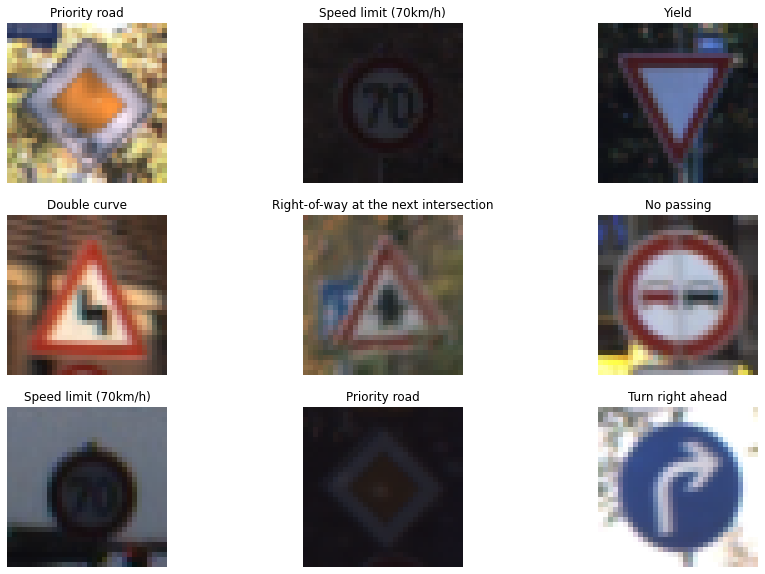

In [142]:
import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np

plt.figure(figsize=(15, 10))
for i in range(9):
    rand_idx = np.random.randint(0, n_train)
    
    # plot random image and its label
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(X_train[rand_idx])
    plt.title(signnames.iloc[y_train[rand_idx]]['SignName'])
    plt.axis("off")
    plt.savefig('./doc_images/examples.png')

View class distribution of the 3 data sets. Although there is some imbalance, the distribution seems similar across the 3 sets.

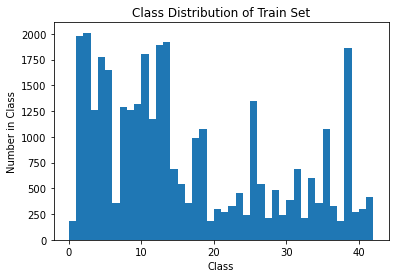

In [147]:
plt.hist(y_train, bins=n_classes-1)
plt.title('Class Distribution of Train Set')
plt.ylabel('Number in Class')
plt.xlabel('Class')
plt.savefig('./doc_images/class_distribution.png')
plt.show()

**TODO:** For each class w/ less than average (or median) frequency, could upsample by generating 'fake' images by perturbing original images.

In [39]:
class_frequencies, _ = np.histogram(y_train, bins=n_classes-1)

print('Average frequency of each class: ', class_frequencies.mean())
print('Median frequency of each class: ', np.median(class_frequencies))

Average frequency of each class:  828.547619047619
Median frequency of each class:  540.0


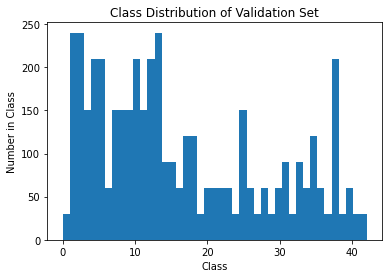

In [40]:
plt.hist(y_valid, bins=n_classes-1)
plt.title('Class Distribution of Validation Set')
plt.ylabel('Number in Class')
plt.xlabel('Class')
plt.show()

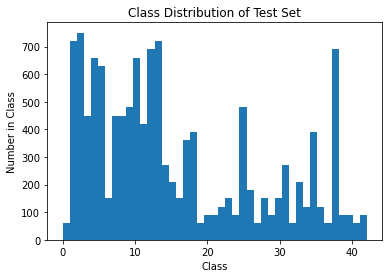

In [41]:
plt.hist(y_test, bins=n_classes-1)
plt.title('Class Distribution of Test Set')
plt.ylabel('Number in Class')
plt.xlabel('Class')
plt.show()

## Pre-Processing

In [42]:
# normalize data 0-1
X_train = X_train/255.
X_valid = X_valid/255.
X_test = X_test/255.

## CNN Model Architecture

Default is the LeNet-5: 
![Lenet-5](doc_images/lenet.png)

In [43]:
import tensorflow as tf

# some parameters
BATCH_SIZE = 128
EPOCHS = 30

#### Low-level TensorFlow Implementation (similar to TF 1): 

In [44]:
def conv(x, W, b, strides):
    """
    Perform convolution with activation
    
    Args:
        x (np.ndarray): input to be convolved
        W (tf.Variable): weights for the 'Xw' part of Xw + b
        b (tf.Variable): biases for the 'b' part of Xw + b
    """
    conv = tf.nn.conv2d(x, W, [1, strides, strides, 1], padding="VALID")
    conv = tf.nn.bias_add(conv, b)
    return tf.nn.relu(conv)

def max_pool(x, k, s):
    """
    Perform max pooling
    
    Args:
        x (np.ndarray): input to be pooled
        k (int): kernel size, sometimes referred to as k or F
        s (int): stride length
    """
    return tf.nn.max_pool(x, ksize=[1, k, k, 1], strides=[1, s, s, 1], padding="VALID")

In [45]:
random_normal = tf.initializers.RandomNormal()

# 'c' conv, 'f' fully connected

weights = {
    # 32x32x3 => 28x28x6 with a 5x5 filter, stride=1
    'wc1': tf.Variable(random_normal([5, 5, 3, 6])),
    # 14x14x6 => 10x10x16 with 5x5 filter, stride=1
    'wc2': tf.Variable(random_normal([5, 5, 6, 16])),
    # 5x5x16 or 400 => 120
    'wf1': tf.Variable(random_normal([400, 120])),
    # 120 => 84
    'wf2': tf.Variable(random_normal([120, 84])),
    # 84 => 43 classes
    'wf3': tf.Variable(random_normal([84, n_classes]))
}

biases = {
    'bc1': tf.Variable(tf.zeros([6])),
    'bc2': tf.Variable(tf.zeros([16])),
    'bf1': tf.Variable(tf.zeros([120])),
    'bf2': tf.Variable(tf.zeros([84])),
    'bf3': tf.Variable(tf.zeros([n_classes]))
}

In [46]:
def low_net(x):
    """Low-level TF 2 (similar to TF 1) implementation of LeNet"""
    # for weight/bias initialization
    mu = 0
    sigma = 0.1
    
    # first conv layer and pooling
    conv1 = conv(x, weights['wc1'], biases['bc1'], strides=1)  # 28x28x6
    pool1 = max_pool(conv1, k=2, s=2)  # 14x14x6
    out1 = tf.nn.relu(pool1)
    
    # second conv layer and pooling
    conv2 = conv(out1, weights['wc2'], biases['bc2'], strides=1)  # 10x10x16
    pool2 = max_pool(conv2, k=2, s=2)  # 5x5x16
    out2 = tf.nn.relu(pool2)
    
    # flatten from 5x5x16 to 400, weights['wf1'].get_shape().as_list()[0]]
    flattened = tf.reshape(out2, 400)
    
    # first fully connected layer
    fc1 = tf.bias_add(tf.matmul(flattened, weights['wf1']), biases['bf1'])
    fc1 = tf.nn.relu(fc1)
    
    # second fully connected layer
    fc2 = tf.bias_add(tf.matmul(fc1, weights['wf2']), biases['bf2'])
    fc2 = tf.nn.relu(fc2)
    
    # last fc layer (output)
    logits = tf.bias_add(tf.matmul(fc2, weights['wf3']), biases['bf3'])
        
    return logits

#### Using TF 2 `layers` and `model` API:

Quite similar to PyTorch API - contstruct a class inheriting from the `Model` module, define the architecture as a series of functions and implement the forward pass or computational graph by calling the functions in a `call(x)` or `forward(x)` method

In [47]:
from tensorflow.keras import Model, layers

In [59]:
class LeNet(Model):
    def __init__(self):
        """Define the architecture"""
        super(LeNet, self).__init__(name="GrantNet")
        
        # conv1: 32x32x3 => 28x28x32 with a 5x5 kernel, stride=1
        # NOTE: 'filters' arg is # of feature maps
        self.conv1 = layers.Conv2D(
            filters=32, kernel_size=5, strides=(1,1), 
            padding="valid", activation=tf.nn.relu
        )
        
        # max pooling: 28x28x32 => 14x14x32 with 2x2 kernel, stride=2; 
        self.pool1 = layers.MaxPool2D(pool_size=2, strides=2, padding="valid")
        
        # conv2: 14x14x32 => 10x10x64 with a 5x5 kernel, stride=1
        self.conv2 = layers.Conv2D(
            filters=64, kernel_size=5, strides=(1,1), 
            padding="valid", activation=tf.nn.relu
        )
        
        # max pooling: 10x10x64 => 5x5x64 with 2x2 kernel, stride=2; 
        self.pool2 = layers.MaxPool2D(pool_size=2, strides=2, padding="valid")
        
        # 5x5x64 => 1600 to be fed into fully connected layers
        self.flatten = layers.Flatten()
        
        # fully connected layer 1
        self.fc1 = layers.Dense(1600, activation='relu')
        
        # dropout
        self.dropout1 = layers.Dropout(rate=0.5)
        
        # fc2
        self.fc2 = layers.Dense(800, activation='relu')
        
        # dropout
        self.dropout2 = layers.Dropout(rate=0.35)
        
        # fc3
        self.fc3 = layers.Dense(400, activation='relu')
        
        # dropout
        self.dropout3 = layers.Dropout(rate=0.25)
        
        # fc4
        self.fc4 = layers.Dense(120, activation='relu')
        
        # dropout
        self.dropout4 = layers.Dropout(rate=0.1)
        
        # output layer
        self.out = layers.Dense(n_classes)
        
    def call(self, x, is_training=False):
        """The forward pass"""
        x = tf.reshape(x, [-1, img_shape[0], img_shape[1], img_shape[2]])
        x = self.conv1(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = self.pool2(x)
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.dropout1(x, training=is_training)  # only dropout in training
        x = self.fc2(x)
        x = self.dropout2(x, training=is_training)
        x = self.fc3(x)
        x = self.dropout3(x, training=is_training)
        x = self.fc4(x)
        x = self.dropout4(x, training=is_training)
        x = self.out(x)
        if not is_training:
            # only apply softmax when predicting
            # tf CE w/ logits function expects logits for training loss
            x = tf.nn.softmax(x)
        return x

In [60]:
# inst. the model
model = LeNet()

#### Keras / TF2 Implementation

## Evaluation

In [61]:
def cross_entropy_loss(logits, y):
    """Compute cross entropy loss given logits and labels (y)"""
    y = tf.cast(y, tf.int64)
    
    # apply softmax to logits and compute cross entropy
    loss = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    
    # return avg loss across entire batch
    return tf.reduce_mean(loss)

def accuracy(pred_logits, y):
    """Compute accuracy given predictions and labels"""
    correct_preds = tf.equal(tf.argmax(pred_logits, 1), tf.cast(y, tf.int64)) # prediction is argmax of logits
    return tf.reduce_mean(tf.cast(correct_preds, tf.float32), axis=-1)

rate = 0.001
optimizer = tf.optimizers.Adam(rate)

## Training

In [62]:
def run_optimization(X, y):
    """Run TF 2 optimization, including forward pass, loss calculation, and backward pass"""
    with tf.GradientTape() as g:
        logits = model(X, is_training=True)
        loss = cross_entropy_loss(logits, y)
        train_accuracy = accuracy(logits, y)
        
    parameters = model.trainable_variables
    gradients = g.gradient(loss, parameters)
    optimizer.apply_gradients(zip(gradients, parameters))  # use gradients to update parameters
    
    return train_accuracy

In [63]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [64]:
from sklearn.utils import shuffle

num_examples = len(X_train)

train_accuracy_list = []
valid_accuracy_list = []

# training loop
for epoch in range(EPOCHS):
    X_train, y_train = shuffle(X_train, y_train)
    print(f'EPOCH {epoch+1}')
    accumulated_accuracy = 0  # running total to compute avg
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_train[offset:offset+BATCH_SIZE], y_train[offset:offset+BATCH_SIZE]

        # optimize and get training accuracy
        batch_accuracy = run_optimization(batch_x, batch_y)
        accumulated_accuracy += batch_accuracy
        
    # average accuracy across batches (accum. acc divided by number of batches)
    train_accuracy = (accumulated_accuracy / (num_examples / BATCH_SIZE))
    train_accuracy_list.append(train_accuracy)
    
    # validate
    valid_preds = model(X_valid, is_training=False)  # returns preds as logits
    valid_accuracy = accuracy(valid_preds, y_valid)
    valid_accuracy_list.append(valid_accuracy)
    
    if epoch % 2 == 0:
        # print results every other epoch
        print(f'Train Accuracy = {train_accuracy:.2%}')
        print(f'Valid Accuracy = {valid_accuracy:.2%}\n')

EPOCH 1
Train Accuracy = 48.20%
Valid Accuracy = 87.21%

EPOCH 2
Train Accuracy = 91.24%
Valid Accuracy = 93.13%

EPOCH 3
Train Accuracy = 96.18%
Valid Accuracy = 93.90%

EPOCH 4
Train Accuracy = 97.71%
Valid Accuracy = 94.65%

EPOCH 5
Train Accuracy = 98.07%
Valid Accuracy = 95.85%

EPOCH 6
Train Accuracy = 98.34%
Valid Accuracy = 96.55%

EPOCH 7
Train Accuracy = 98.72%
Valid Accuracy = 94.67%

EPOCH 8
Train Accuracy = 98.58%
Valid Accuracy = 95.10%

EPOCH 9
Train Accuracy = 98.83%
Valid Accuracy = 96.73%

EPOCH 10
Train Accuracy = 99.11%
Valid Accuracy = 95.42%

EPOCH 11
Train Accuracy = 99.04%
Valid Accuracy = 96.10%

EPOCH 12
Train Accuracy = 99.26%
Valid Accuracy = 96.33%

EPOCH 13
Train Accuracy = 99.15%
Valid Accuracy = 97.01%

EPOCH 14
Train Accuracy = 99.16%
Valid Accuracy = 95.62%

EPOCH 15
Train Accuracy = 99.27%
Valid Accuracy = 95.87%

EPOCH 16
Train Accuracy = 99.41%
Valid Accuracy = 96.67%

EPOCH 17
Train Accuracy = 99.24%
Valid Accuracy = 96.87%

EPOCH 18
Train Accuracy

In [65]:
print(model.summary())

Model: "GrantNet"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            multiple                  2432      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 multiple                  0         
_________________________________________________________________
conv2d_5 (Conv2D)            multiple                  51264     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 multiple                  0         
_________________________________________________________________
flatten_2 (Flatten)          multiple                  0         
_________________________________________________________________
dense_10 (Dense)             multiple                  2561600   
_________________________________________________________________
dropout_8 (Dropout)          multiple                  0  

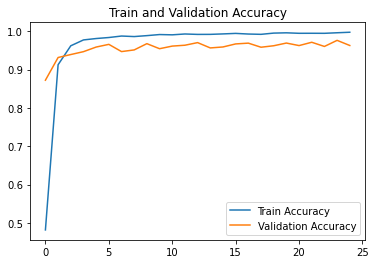

In [145]:
plt.plot(range(EPOCHS), train_accuracy_list, label='Train Accuracy')
plt.plot(range(EPOCHS), valid_accuracy_list, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Train and Validation Accuracy')
plt.savefig('./doc_images/accuracy.png')
plt.show()

### Tracking Validation Performance:
- Validation Accuracy = 91%, `EPOCHS` = 20, original LeNet architecture
- Validation Accuracy = 95%, `EPOCHS` = 20, original LeNet architecture, **added 50/30/10 dropout in FC layers**
- Validation Accuracy = 96%, `EPOCHS` = 20, **new architecture (3=>32=>64 feature maps, 1600=>800=>400=>120=>n_classes FC layers) , **50/35/25/10 dropout in FC layers**

## Test

In [99]:
# test
test_preds = model(X_test, is_training=False)  # returns preds as logits
test_accuracy = accuracy(test_preds, y_test)
print(f'Test Accuracy = {test_accuracy}')

Test Accuracy = 0.9537608623504639


#### View Test Performance on Specific Images from Test Set

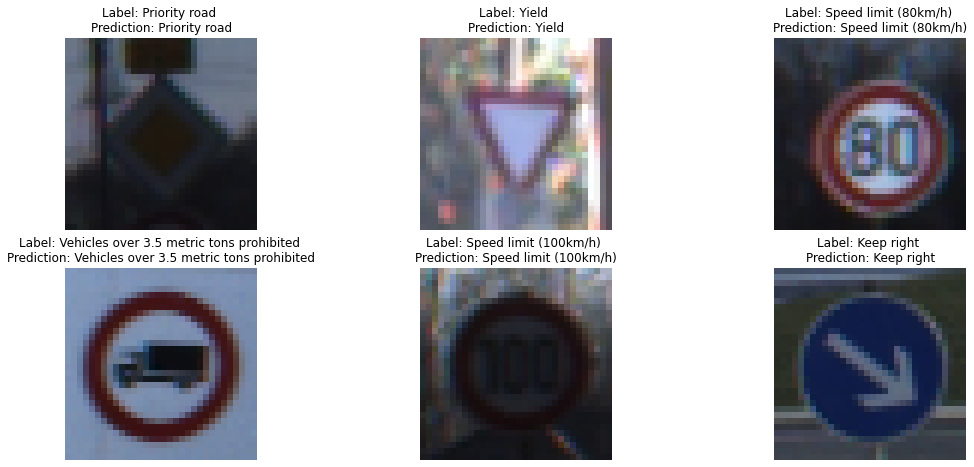

In [148]:
plt.figure(figsize=(18, 12))
for i in range(6):
    rand_idx = np.random.randint(0, n_test)
    
    # get prediction
    pred = model(X_test[rand_idx], is_training=False)
    
    # plot random image and its label
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(X_test[rand_idx])
    plt.title(f'Label: {signnames.iloc[y_test[rand_idx]]["SignName"]} \nPrediction: {signnames.iloc[pred.numpy().argmax()]["SignName"]}')
    plt.axis("off")
    plt.savefig('./doc_images/test.png')

### Error Analysis
Inspecting the errors the network is making

In [100]:
test_preds = tf.argmax(test_preds, 1).numpy()
y_test = tf.cast(y_test, tf.int64).numpy()

In [104]:
incorrect_preds = test_preds[test_preds != y_test]
labels_of_incorrect_preds = y_test[test_preds != y_test]

Look at distribution of classes amongst incorrect predictions and the true labels

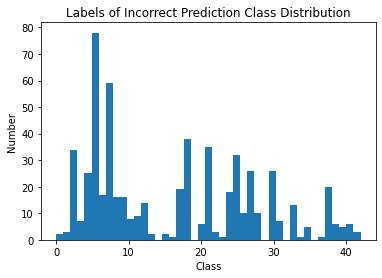

In [111]:
plt.hist(labels_of_incorrect_preds, bins=n_classes-1)
plt.title('Labels of Incorrect Prediction Class Distribution')
plt.ylabel('Number')
plt.xlabel('Class')
plt.show()

In [123]:
freq, labels = np.histogram(labels_of_incorrect_preds, bins=n_classes-1)
print(freq)
print(labels)

[ 2  3 34  7 25 78 17 59 16 16  8  9 14  2  0  2  1 19 38  0  6 35  3  1
 18 32 10 26 10  0 26  7  0 13  1  5  0  1 20  6  5  9]
[ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42.]


In [124]:
# get k most misclassified classes
k = 2
topk = np.argsort(freq)[::-1][:k]

# model especially has trouble with class labels 5 (78 incorrect) and 7 (59 incorrect)
for label in topk:
    print(signnames.iloc[label])

ClassId                        5
SignName    Speed limit (80km/h)
Name: 5, dtype: object
ClassId                         7
SignName    Speed limit (100km/h)
Name: 7, dtype: object


For some reason, the model has lots of trouble with speed limit signs of 80km/h and 100km/h

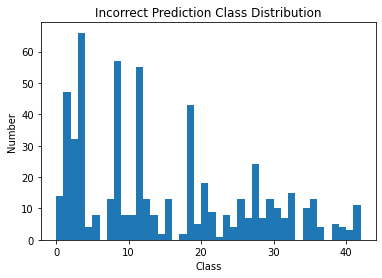

In [125]:
plt.hist(incorrect_preds, bins=n_classes-1)
plt.title('Incorrect Prediction Class Distribution')
plt.ylabel('Number')
plt.xlabel('Class')
plt.show()

In [127]:
freq, labels = np.histogram(incorrect_preds, bins=n_classes-1)
print(freq)
print(labels)

[14 47 32 66  4  8  0 13 57  8  8 55 13  8  2 13  0  2 43  5 18  9  1  8
  4 13  7 24  7 13 10  7 15  0 10 13  4  0  5  4  3 11]
[ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42.]


In [128]:
# get predictions of k most misclassified classes
k = 2
topk = np.argsort(freq)[::-1][:k]

# model especially has trouble with class labels 5 (78 incorrect) and 7 (59 incorrect)
for label in topk:
    print(signnames.iloc[label])

ClassId                        3
SignName    Speed limit (60km/h)
Name: 3, dtype: object
ClassId                         8
SignName    Speed limit (120km/h)
Name: 8, dtype: object


Speed limit (60km/h) and Speed limit (120km/h) are the most common incorrect predictions. To get a better idea of the mistakes, let's look at this most common misclassification pairs: `(pred, label)`

In [140]:
# count the frequencies of each pair
freq_map = {}
for pair in zip(incorrect_preds, labels_of_incorrect_preds):
    freq_map[pair] = freq_map.get(pair, 0) + 1
    
# sort based on number of times this pair showed up
freq_map_sorted = sorted(freq_map, key=freq_map.get, reverse=True)

k = 5
print('Most common misclassifications: \n')
for pair in freq_map_sorted[:k]:
    print(f'Prediction = [{signnames.iloc[pair[0]]["SignName"]}], Label = [{signnames.iloc[pair[1]]["SignName"]}] happened {freq_map[pair]} times')

Most common misclassifications: 

Prediction = [Speed limit (120km/h)], Label = [Speed limit (100km/h)] happened 52 times
Prediction = [Speed limit (50km/h)], Label = [Speed limit (80km/h)] happened 25 times
Prediction = [Speed limit (60km/h)], Label = [Speed limit (80km/h)] happened 23 times
Prediction = [Speed limit (60km/h)], Label = [Speed limit (50km/h)] happened 21 times
Prediction = [Pedestrians], Label = [General caution] happened 19 times


**Error Analysis Conclusion:** Most misclassifications are happening with _speed limit signs_, indicating the model is having trouble with the subtle differences in the numbers represented on a sign.

#### Test Images Taken From Internet

## Vizualize layers